<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy.fft import fftfreq

In [2]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [3]:
# get historical market data
hist = cat.history(period="max")

In [4]:
hist = hist["Open"].to_frame()

In [5]:
# Convert the index from timestamp to date
hist = hist.reset_index()
hist["Date"] = hist["Date"].dt.date
hist = hist.set_index("Date")

<Axes: xlabel='Date'>

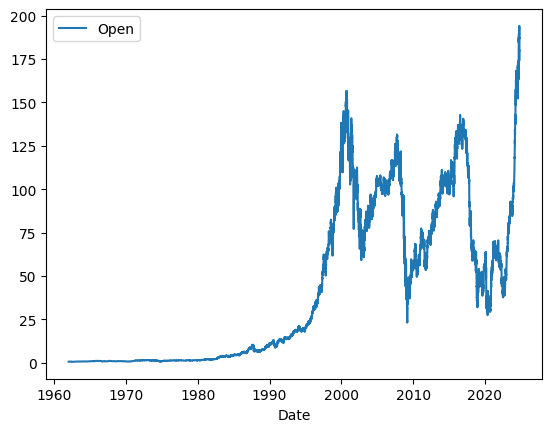

In [6]:
hist.reset_index().plot(x="Date",y="Open")

## Imputing Missing Values
For some timesteps some values may be missing therefore we impute cnsidering the last not-null value

In [7]:
# Check if all the data points are equally spaced

beginning_timestamp = hist.index.min()
last_timestamp = hist.index.max()
delta_t = hist.index[1] - beginning_timestamp


equispaced_index = pd.date_range(start = beginning_timestamp,
              end = last_timestamp,
              freq = delta_t
)

equispaced_df = pd.DataFrame(index = equispaced_index,
             data = {"test_col" : np.zeros(equispaced_index.size)}
).reset_index()


equispaced_df["index"] = equispaced_df["index"].dt.date

hist = equispaced_df.merge(hist.reset_index(),
                    how='left',
                    left_on = 'index',
                    right_on='Date'
)

cols = ["index", "Open"]

hist = hist[cols]

In [8]:
# Imputing the nulls with the last non null value

nulls_indices = hist[hist["Open"].isna()].index.copy()

for idx in nulls_indices:

  if idx == 0:
    hist.iloc[(idx, 1)] = 0.0
  elif idx >= 1:
    hist.iloc[(idx, 1)] = hist.iloc[(idx - 1, 1)]

hist.rename(columns={"index": "Date"}, inplace=True)

hist = hist.set_index("Date")

In [9]:
hist.describe()

,Open
count,22947.000000
mean,41.701482
std,45.584979
min,0.468906
25%,1.396809
50%,17.786287
75%,79.515246
max,194.089996


## Moving Average Derivation

Suppose we have a time series:

\begin{align}
x_t \hspace{2cm} t=0,1,..,T-1
\end{align}


And its cumulative sum:

\begin{align}
c_t = \sum_{i=0}^t x_i
\end{align}

And we want to compute the moving average at time step $t$, by considering the $w$ previous time steps ($t$ is also included):

\begin{align}
\overline{x}_t = \frac{1}{w} \sum_{i = t-w+1}^t x_i \hspace{2cm} \, for \, t = w-1,...,T-1.
\end{align}

The cumulative sum at time $t$ can be written as:

\begin{align}
c_t = \sum_{i=0}^t x_i = \sum_{i=0}^{t-w} x_i \, + \, \sum_{i=t-w+1}^{t} x_i = c_{t-w} \, + \, w\, \overline{x}_t
\end{align}

The previous formula is defined for $t=w,...,T-1$ as can be seen by inspecting the upper extreme of the first sum and considering that $x_t$ is definited for $t\ge0$, therefore:

\begin{align}
\overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{align}

To find $\overline{x}_t$ at time $t=w-1$ we use the definition:

\begin{align}
\overline{x}_{w-1} = \frac{1}{w} \sum_{i = (w-1)-w+1}^{w-1} x_i = \frac{1}{w} \sum_{i = 0}^{w-1} x_i = \frac{1}{w} c_{w-1}.
\end{align}

Overall, the moving average can be computed via:

\begin{cases}
      \overline{x}_{w-1} = \frac{1}{w} c_{w-1}\\
      \overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{cases}


### Algorithm definition

If we want to use a unique array called mov we can implement the following algorithm:

1. Define variable **mov** as the cumulative average.
2. Modify the elemnts of the array mov from the index $w$ by using
   the difference:
   
   **mov[w:] = mov[w:] - mov[:-w]**

3. Note that mov[w-1] has still the initial value equal to the
   cumulative sum at $t=w-1$ therefore we return the array:

   **(1/w)  mov[w-1:]**


This algorithm is implemented in the function moving_average_forecast:

In [10]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)

  # This is necessary because to subtract two pandas series it is necessary
  # That both series have the same index. Therefore we force the series
  # mov[window_size:] and mov[:-window_size] to have the same index

  index = pd.Index(
      list(
          range(mov.size - window_size)
      )
  )

  mov[window_size:] = mov[window_size:].set_axis(index)- mov[:-window_size].set_axis(index)

  return mov[window_size - 1:] / window_size

In [11]:
window_size = 1

mov_average_col = "Open_mov_avg"
hist[mov_average_col] = moving_average_forecast(hist["Open"], window_size)

<Axes: xlabel='Date'>

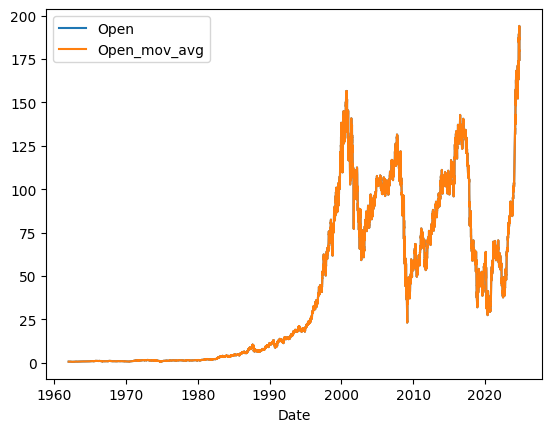

In [12]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_mov_avg"])

### First Difference

The first difference is defined as:
$d_t = x_t - x_{t-q} \hspace{2cm} t=q,..., T-1$

Therefore it can be implemenentate in the function diff_series following the algoritm:

1. Define the original series as the variable **series**

2. Return the difference **series[q:] - series[:-q]**

In [13]:
def diff_series(series, q):
  original_index = series.index.copy()

  # saving te first q values in cae we want to recnstruct te original
  # series
  first_q_values = series[:q].to_numpy(copy=True)

  # Removal of the first t0-1 indices
  original_index = original_index.delete(list(range(q)))

  # conversion into numpy array to avoid indices mismatches
  series = series[q:].to_numpy(copy=True) - series[:-q].to_numpy(copy=True)

  # Returning the final pandas series from the previous numpy array
  return pd.Series(series, index=original_index), first_q_values, original_index

In [14]:
hist["Open_diff"], first_q_values, original_index =  diff_series(hist["Open"], 3)

<Axes: xlabel='Date'>

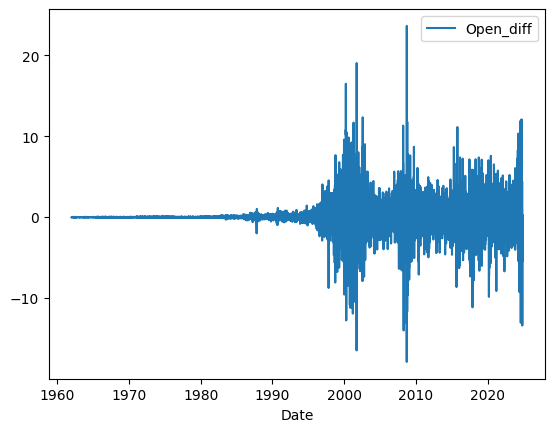

In [15]:
hist.reset_index().plot(x="Date", y="Open_diff")

### Series Integration

In order to reconstruct the original series from the differenced one we consider the first difference written for te first term of te original series as:

$x_{t_0+q}=  x_{t_0} + d_{t_0+q} \hspace{1cm} t_0=0, ...,q-1$

$x_{t_0+2q}=  x_{t_0 + q} + d_{t_0+2q} \hspace{1cm} t_0=0, ...,q-1$

Therefore:

$x_{t_0+2q}=  x_{t_0} + d_{t_0+q} + d_{t_0+2q} \hspace{1cm} t_0=0, ...,q-1$

Reasoning by induction we find then:

$x_{t_0+nq}=  x_{t_0} + \sum_{k=1}^n d_{t_0+kq}  \hspace{1cm} t_0=0, ...,q-1$

if we definw the $q$ subseries:

$d^0 = d_{t_0 + kq}  \hspace{1cm} k=1,...,n$ we apply cumulative sum and add $x_{t_0}$ we find the subseries $x_{t_0+nq}$. All the $q$ subseries (obtained by changing $t_0$) can be then used to reconstruct the full original series $x_t$.


In [16]:
def integrate_series(first_q_values, series):

  """Function to reconstruct a differenced time series given the first
     q  values of the original series"""

  original_index = series.index

  q = first_q_values.size
  T = series.size

  # Creation of an annay of zeros with the final size of the time series
  result = np.zeros(shape= T)

  # Restablishing the first q values of the original series
  result[:q] = first_q_values

  # Creation of the q subseries
  for t0 in range(q):
    sub_series = series[t0+q::q].to_numpy()

    sub_series = first_q_values[t0] + np.cumsum(sub_series)

    # Population of the subseries
    for k in range(len(sub_series)):
      result[t0 + (k+1)*q] = sub_series[k]

  return pd.Series(result, index = original_index)

In [17]:
hist["Open_diff_integrated"] = integrate_series(first_q_values, hist["Open_diff"])

<Axes: xlabel='Date'>

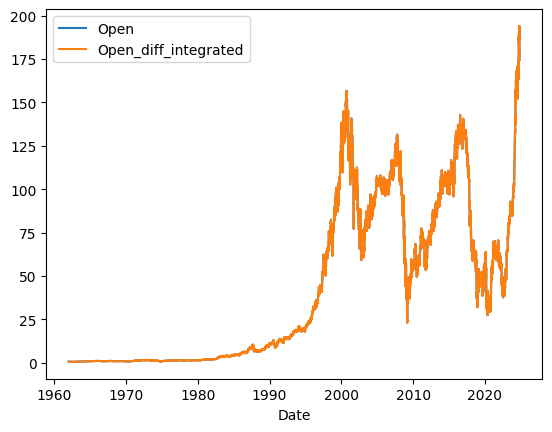

In [18]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_diff_integrated"])

## Training and Validation Test Split

In [19]:
number_time_steps = hist.shape[0]
train_perc = 80.0
train_index = int(np.floor(number_time_steps * train_perc/100.0))

train_set = hist.iloc[:train_index]
val_set = hist.iloc[train_index:]

## Naive Forecast

Naive forecast predicts value at time $t+1$ as equal to the value of the series at time $t$. This will be our baseline model to evaluate all the models against it. Note that naive forecast $\hat{x}_{t+1}$ is equivalent to moving average $\overline{x}_t$ at time $t$ with $w=1$ in fact:

\begin{align}
\hat{x}_{t+1} \approx \overline{x}_t = \frac{1}{1} \sum_{i = t-1+1}^t x_i = \sum_{i = t}^t x_i = x_{t}
\end{align}


In [20]:
data_one_time_tep_before = hist["Open"][train_index - 1:-1].values

val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )

<ipython-input-20-c56b9a4f2e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )


<Axes: xlabel='Date'>

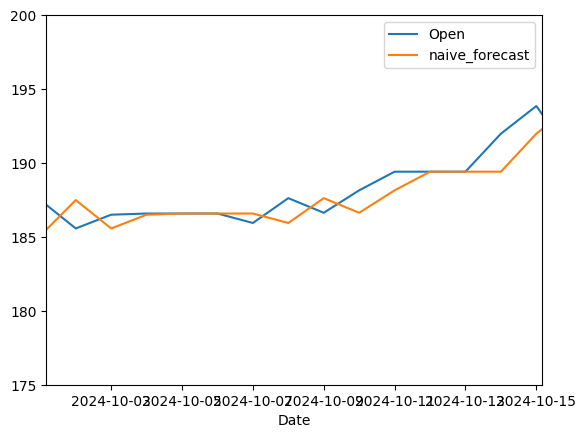

In [21]:
val_set.reset_index().plot(x="Date",
                           y=["Open", "naive_forecast"],
                           xlim = ('2024-10-01 00:00:00-04:00', '2024-10-15 00:00:00-04:00'),
                           ylim = (175, 200))

In [22]:
errors = val_set["Open"] - val_set["naive_forecast"]
abs_errors = np.abs(errors)
MAE = abs_errors.mean()
print(f"The Mean Absolute Error (MAE) for the naive forecast is {MAE}")

The Mean Absolute Error (MAE) for the naive forecast is 0.6986452796247076


## Moving Average Forecast

### Fourier Transform
Fourier transform and Power Spectral Density (PSD) are used to find seasonality in the timeseries. The frequencies of seasonality may be identifying by peaks in the PSD.

In [23]:
from scipy.fft import fft, ifft

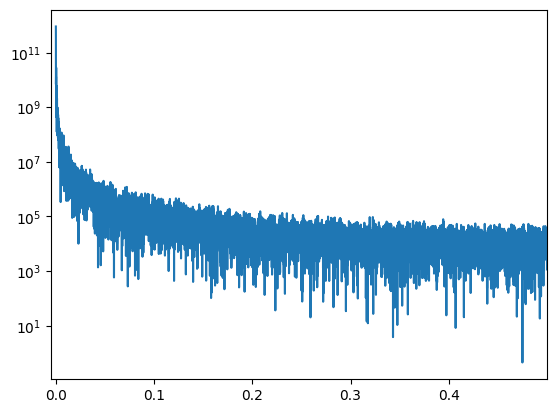

In [24]:
# Number of time steps
N = equispaced_index.size

# frequencies in cycles/delta_t. Only the positive frequencies are taken
# because the function is real and the FFT is symmetric
frequencies = fftfreq(N, d = 1)[:N//2]

# Discrete Fourier Transform computation. Only te values with Re[ft] >= 0 are taken
ft = fft(hist["Open"].values)[:N//2]

max_frequency = np.max(frequencies)

# POwer Spectral Density (fft^2)
psd = np.square(np.abs(ft))

import matplotlib.pyplot as plt

plt.xlim(-0.005,max_frequency)

plt.yscale("log")
plt.plot(frequencies, psd)

Therefore there is no seasonality in the time series. Let's consider the moving average in the validation set with varying window size :

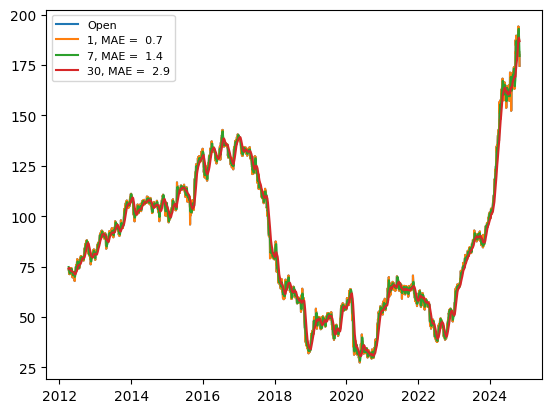

In [25]:
windows = [1, 7, 30]

true_val = val_set["Open"]


plt.plot(val_set.index, true_val, label = "Open")

for w in windows:

  mov_val = moving_average_forecast(hist["Open"][train_index - w:], w)
  pred_val_index = mov_val.index + delta_t
  pred_val = pd.Series(mov_val.values, index = pred_val_index)[:-1]

  errors = true_val - pred_val
  abs_errors = np.abs(errors)
  MAE = abs_errors.mean()

  label = f"{str(w)}, MAE = {MAE:{4}.{2}}"

  plt.plot(mov_val.index, mov_val, label = label)

plt.legend(loc="upper left")
plt.legend(fontsize = 8.0)
plt.show()

## Machine Learning

## Stationarity Check

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
diff = hist["Open_diff"][~hist["Open_diff"].isna()].values

In [28]:
ADF = adfuller(diff, regression = 'c')
test_statistic = ADF[0]
p_value = ADF[1]

In [29]:
significance = 0.05
if p_value < significance:
  msg = "The series is stationary because there is not unit root in the series "
  msg += f"\nbased on a significance of {significance*100}% (Alternate Hypothesis)."

  print(msg)

The series is stationary because there is not unit root in the series 
based on a significance of 5.0% (Alternate Hypothesis).


### Partial Auto Correlation Function (PACF)

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [31]:
def plot_PACF(series, confidence=0.95, lags=40, fig_width=12, fig_height=6):

  """Function to plot the partial autcorrelation function"""
  plt.figure(figsize=(fig_width, fig_height))
  plot_pacf(series, lags=lags, alpha = 1.0 - confidence)
  plt.xlabel('lag')
  plt.ylabel('PACF')
  plt.show()

In [32]:
def plot_ACF(series, confidence=0.95, lags=40, fig_width=12, fig_height=6):

  """Function to plot the autcorrelation function"""
  plt.figure(figsize=(fig_width, fig_height))
  plot_acf(series, lags=lags, alpha = 1.0 - confidence)
  plt.xlabel('lag')
  plt.ylabel('ACF')
  plt.show()

<Figure size 1200x600 with 0 Axes>

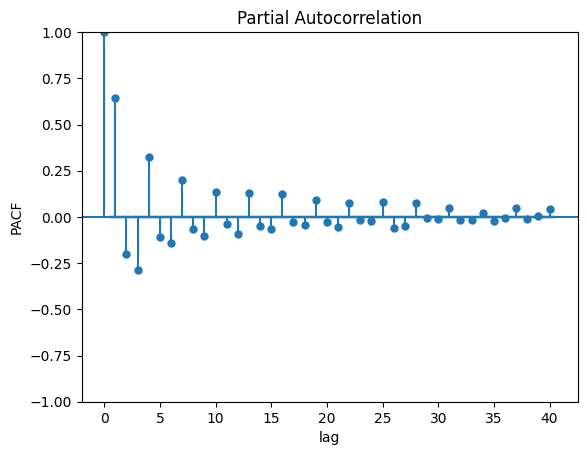

In [33]:
plot_PACF(diff)

<Figure size 1200x600 with 0 Axes>

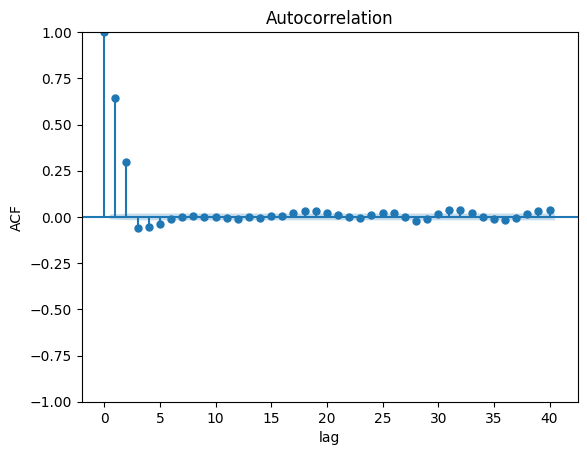

In [34]:
plot_ACF(diff)

### Time Window

We want to forecast the next value of a time series using a time window made of the previous $n_w$ time steps. Each time window will have an initial time represented by the second time instant of the preceding window. For example for window $j$ and $j+1$ we will have:

\begin{aligned}
window_j: \hspace{2cm} t_j, t_{j+1}, ... , t_{j+n_w-1}, \\
window_{j+1}: \hspace{2cm} {t_{j+1}}, t_{j+2}, ... , t_{j+n_w}
\end{aligned}

In order to train a supervised machine learning model we need a label for each training sample. In this case, we will have that for each window the first $n_{w-1}$ time steps represents the training sample while the last time step $t_{n_w}$ represents the target to predict.


In [35]:
import tensorflow as tf

In [36]:
diff_training_values = diff[:train_index]
diff_validation_values = diff[train_index:]

In [37]:
# Creation of a tensorflow dataset from list
diff_train_set = tf.data.Dataset.from_tensor_slices(diff_training_values)
diff_val_set = tf.data.Dataset.from_tensor_slices(diff_validation_values)

In [38]:
samples_per_window = 10
# Shift used to make a window starting with the second time step of the previous
# window
# Drop Remainder is used to obtain all windows with an equal number of samples_per_window
# Beacuse ML models expect same number of training examples in each window
diff_train_set = diff_train_set.window(size=samples_per_window, shift=1, drop_remainder=True)
diff_val_set = diff_val_set.window(size=samples_per_window, shift=1, drop_remainder=True)

# Storing te numer of windows into a variable used later to shaffle
# the dataset
number_of_windows_train = tf.data.experimental.cardinality(diff_train_set).numpy()
number_of_windows_val = tf.data.experimental.cardinality(diff_train_set).numpy()

In [39]:
# Printing the structure of the windows for the first
# five windows to check data
for idx, window in enumerate(diff_train_set.take(5)):
  string = f"WINDOW {idx}: "
  for elem in window:
    string += f"{str(elem.numpy())[:8]} "

  print(string)

WINDOW 0: -0.01561 -0.01041 -0.00728 -0.01561 -0.01666 -0.01353 0.005206 0.007289 0.004165 0.001041 
WINDOW 1: -0.01041 -0.00728 -0.01561 -0.01666 -0.01353 0.005206 0.007289 0.004165 0.001041 -0.00728 
WINDOW 2: -0.00728 -0.01561 -0.01666 -0.01353 0.005206 0.007289 0.004165 0.001041 -0.00728 -0.00208 
WINDOW 3: -0.01561 -0.01666 -0.01353 0.005206 0.007289 0.004165 0.001041 -0.00728 -0.00208 0.002082 
WINDOW 4: -0.01666 -0.01353 0.005206 0.007289 0.004165 0.001041 -0.00728 -0.00208 0.002082 -0.00312 


In [40]:
# Conversion of each window into a tensor.
# The batch method takes a number of samples_per_window and create a tensor
# The falt_map method run a function on a each dataset part of a nested
# dataset

diff_train_set = diff_train_set.flat_map(lambda window: window.batch(samples_per_window))
diff_val_set = diff_val_set.flat_map(lambda window: window.batch(samples_per_window))

In [41]:
# Printing the tensors that constitute the dataset
for idx, window in enumerate(diff_train_set.take(5)):
  print(f"TENSOR {idx}: {window.numpy()}")

TENSOR 0: [-0.01561991 -0.01041311 -0.00728954 -0.01561872 -0.01666002 -0.01353622
  0.0052066   0.00728903  0.00416523  0.00104112]
TENSOR 1: [-0.01041311 -0.00728954 -0.01561872 -0.01666002 -0.01353622  0.0052066
  0.00728903  0.00416523  0.00104112 -0.00728832]
TENSOR 2: [-0.00728954 -0.01561872 -0.01666002 -0.01353622  0.0052066   0.00728903
  0.00416523  0.00104112 -0.00728832 -0.00208221]
TENSOR 3: [-0.01561872 -0.01666002 -0.01353622  0.0052066   0.00728903  0.00416523
  0.00104112 -0.00728832 -0.00208221  0.00208229]
TENSOR 4: [-0.01666002 -0.01353622  0.0052066   0.00728903  0.00416523  0.00104112
 -0.00728832 -0.00208221  0.00208229 -0.00312442]


In [42]:
# We split each tensor into two tensors one representing the input features and
# the other the representing the target. The map method maps each tensor, part of
# the dataset into a couple of tensors. The first tensor has the first samples_per_window -1
# samples while the last has only the last sample

diff_train_set = diff_train_set.map(lambda window: (window[:-1], window[-1:]))
diff_val_set = diff_val_set.map(lambda window: (window[:-1], window[-1:]))

In [43]:
for input_sample, target_sample in diff_train_set.take(5):
  print(f"INPUT SAMPLE: {input_sample.numpy()} ", f"TARGET: {target_sample.numpy()}")

INPUT SAMPLE: [-0.01561991 -0.01041311 -0.00728954 -0.01561872 -0.01666002 -0.01353622
  0.0052066   0.00728903  0.00416523]  TARGET: [0.00104112]
INPUT SAMPLE: [-0.01041311 -0.00728954 -0.01561872 -0.01666002 -0.01353622  0.0052066
  0.00728903  0.00416523  0.00104112]  TARGET: [-0.00728832]
INPUT SAMPLE: [-0.00728954 -0.01561872 -0.01666002 -0.01353622  0.0052066   0.00728903
  0.00416523  0.00104112 -0.00728832]  TARGET: [-0.00208221]
INPUT SAMPLE: [-0.01561872 -0.01666002 -0.01353622  0.0052066   0.00728903  0.00416523
  0.00104112 -0.00728832 -0.00208221]  TARGET: [0.00208229]
INPUT SAMPLE: [-0.01666002 -0.01353622  0.0052066   0.00728903  0.00416523  0.00104112
 -0.00728832 -0.00208221  0.00208229]  TARGET: [-0.00312442]


In [44]:
# When a ML model is trained it is necessary that the samples are
# Independent and and Identically Distributed (IID)
# IID can be guaranteed by shuffllying the dataset
# therefore the order of the windows in the dataset changes but the structure
# of each window remains the same

diff_train_set = diff_train_set.shuffle(buffer_size = number_of_windows_train)
#diff_val_set = diff_train_set.shuffle(buffer_size = number_of_windows_val)

In [45]:
# Showing the shuffled dataset
for input_sample, target_sample in diff_train_set.take(5):
  print(f"INPUT SAMPLE: {input_sample.numpy()} ", f"TARGET: {target_sample.numpy()}")

INPUT SAMPLE: [-2.13596298e-02 -1.88465380e-02 -1.75899872e-02 -2.51268678e-03
  1.54352254e-07  6.28193106e-03  1.50769571e-02  1.25642080e-02
  2.68118396e-07]  TARGET: [-0.00251284]
INPUT SAMPLE: [ 0.00957555  0.01063956  0.01595844 -0.00425545  0.0095747   0.00957502
  0.02021425  0.00531944  0.00957501]  TARGET: [-0.00106423]
INPUT SAMPLE: [0.01776266 0.0142104  0.01184183 0.00236862 0.00146729 0.0086254
 0.01341493 0.02982708 0.02266898]  TARGET: [0.01551081]
INPUT SAMPLE: [ 0.01965918 -0.05899451  0.17701527  0.2360163   0.40318232  0.04916497
 -0.00983606 -0.11800757 -0.10817352]  TARGET: [-0.29500896]
INPUT SAMPLE: [ 1.33524423  1.16406051  1.74609613  0.          0.68474285  4.27964143
  0.85593403  2.12270072 -0.30814283]  TARGET: [3.11556458]


In [46]:
windows_per_batch = 2

# Creating mini batches of windows_per_batch
diff_train_set = diff_train_set.batch(windows_per_batch).prefetch(1)
diff_val_set = diff_val_set.batch(windows_per_batch).prefetch(1)

In [47]:
for idx, (X_train, Y_train) in enumerate(diff_train_set.take(5)):
  print(f"BATCH {idx}:\nX_train={X_train.numpy()}, Y_train={Y_train.numpy()}")

BATCH 0:
X_train=[[ 0.0384956  -0.21171551 -0.17322093 -0.02887162  0.22133949  0.18284491
  -0.09623481  0.01924779  0.00962323]
 [-0.01930679 -0.03008163 -0.00269077  0.00537904  0.01882845 -0.02151709
  -0.04572528 -0.04572607 -0.01614032]], Y_train=[[-0.08661164]
 [ 0.03227678]]
BATCH 1:
X_train=[[ 0.27157334  1.72003657  2.26322406  2.98745527  1.56919413  1.02600663
   0.03020209  0.8751074   0.5733421 ]
 [-0.04509597  0.22548698  0.29315259  0.29314572  0.09020588 -0.47354653
  -0.38335235 -0.36079943 -0.15784878]], Y_train=[[ 0.12068328]
 [-0.27059555]]
BATCH 2:
X_train=[[-1.26825678e-02 -3.92034964e-02 -6.91815445e-03 -8.07164313e-03
   1.84492854e-02  4.88381280e-07  1.15290777e-03 -5.76622238e-03
  -1.15309411e-02]
 [ 1.94631254e+00  1.63150210e+00 -6.58278384e-01 -8.01406689e-01
  -1.20216638e+00  3.72098328e-01 -1.20214767e+00  5.72419692e-01
  -4.00711021e+00]], Y_train=[[-0.02075546]
 [-2.43286421]]
BATCH 3:
X_train=[[-1.46843580e+00  3.39374775e+00  2.93689972e+00  2.12

In [48]:
for idx, (X_val, Y_val) in enumerate(diff_val_set.take(5)):
  print(f"BATCH {idx}:\nX_train={X_val.numpy()}, Y_train={Y_val.numpy()}")

BATCH 0:
X_train=[[-1.91330773 -1.83825408 -2.21340673 -0.3376259   0.22506173  0.60021439
   0.63774128 -0.75029356 -0.56270934]
 [-1.83825408 -2.21340673 -0.3376259   0.22506173  0.60021439  0.63774128
  -0.75029356 -0.56270934  0.18759274]], Y_train=[[0.18759274]
 [0.71277299]]
BATCH 1:
X_train=[[-2.21340673 -0.3376259   0.22506173  0.60021439  0.63774128 -0.75029356
  -0.56270934  0.18759274  0.71277299]
 [-0.3376259   0.22506173  0.60021439  0.63774128 -0.75029356 -0.56270934
   0.18759274  0.71277299  1.50062846]], Y_train=[[1.50062846]
 [0.75032637]]
BATCH 2:
X_train=[[ 0.22506173  0.60021439  0.63774128 -0.75029356 -0.56270934  0.18759274
   0.71277299  1.50062846  0.75032637]
 [ 0.60021439  0.63774128 -0.75029356 -0.56270934  0.18759274  0.71277299
   1.50062846  0.75032637  0.97543968]], Y_train=[[ 0.97543968]
 [-1.3880953 ]]
BATCH 3:
X_train=[[ 0.63774128 -0.75029356 -0.56270934  0.18759274  0.71277299  1.50062846
   0.75032637  0.97543968 -1.3880953 ]
 [-0.75029356 -0.56270

## Linear Regression Model ( Classical AR Model)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.losses import Huber

In [50]:
# We create a model with one Dense layer. By default the dense layer
# uses a linear activation function for all neurons. Therefore we will
# have a linear regression where the features are the previous n_w-1 time
# steps and the target is n_w-th time step

linear_model = Sequential([
  Dense(1, input_shape=[samples_per_window - 1])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
# Optimizer. Stochasting Gradient Descend with learning rate e-05
optimizer = SGD(learning_rate=1e-5, momentum=0.9)
linear_model.compile(loss=Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [63]:
linear_model.fit(diff_train_set, epochs=12, validation_data=diff_val_set)

Epoch 1/12
   9164/Unknown 19s 2ms/step - loss: 0.2863 - mae: 0.4481

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9174/9174 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.2863 - mae: 0.4481 - val_loss: 0.7051 - val_mae: 1.0917
Epoch 2/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.2684 - mae: 0.4243 - val_loss: 0.6791 - val_mae: 1.0624
Epoch 3/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.2848 - mae: 0.4438 - val_loss: 0.6578 - val_mae: 1.0381
Epoch 4/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2603 - mae: 0.4149 - val_loss: 0.6393 - val_mae: 1.0164
Epoch 5/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.2508 - mae: 0.4035 - val_loss: 0.6231 - val_mae: 0.9973
Epoch 6/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.2412 - mae: 0.3938 - val_loss: 0.6095 - val_mae: 0.9806
Epoch 7/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.2424 - mae: 0.3952 - val_loss: 0.5986 - val_mae: 0.9678
Epoch 8/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2420 - mae: 0.3919 - val_loss: 0.5886 - val_mae: 0.9556
Epoch 9/12
9174/9174 ━━━━━━━━━━━━━━━━━━━━ 1

In [64]:
def get_val_dataset(series, samples_per_window=2, windows_per_batch=2):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=samples_per_window - 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(samples_per_window))
  dataset  = dataset.batch(windows_per_batch).prefetch(1)
  return dataset

In [65]:
test =  get_val_dataset(diff_training_values, samples_per_window= samples_per_window)

In [66]:
diff_pred = linear_model.predict(test)

9175/9175 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


(-10.0, 10.0)

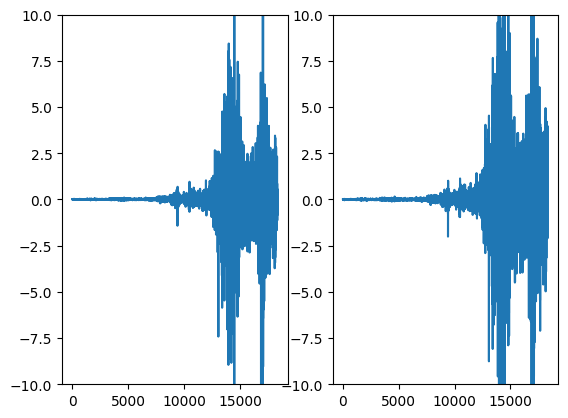

In [67]:
fig, axes = plt.subplots(1,2)
axes[0].plot(diff_pred, label='diff_pred')
axes[0].set_ylim(-10,10)
axes[1].plot(diff_training_values[samples_per_window - 2:], label='diff_validation')
axes[1].set_ylim(-10,10)